In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [20]:
from __future__ import annotations
from typing import Any, Callable, List, Optional, Tuple

import os
import sys
sys.path.append("../") # So we can use the coordination package

import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns

from coordination.model.synthetic.conversation import ConversationModel
from coordination.model.synthetic.spring import SpringModel
from coordination.model.config_bundle.conversation import ConversationConfigBundle
from coordination.model.config_bundle.spring import SpringConfigBundle
from coordination.module.coordination.sigmoid_gaussian_coordination import SigmoidGaussianCoordinationSamples
from coordination.module.observation.observation import ObservationSamples
from coordination.inference.inference_data import InferenceData

# Style

In [3]:
sns.set_style("white")
tex_fonts = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.titlesize": 8,
    "axes.linewidth": 1
}
plt.rcParams.update(tex_fonts)
plt.rc('pdf',fonttype = 42)
plt.rcParams['text.usetex'] = True

DOC_WIDTH = 400

## Helper functions

In [4]:
def calculate_best_figure_dimensions(document_width: Union[str, float], scale=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    document_width: Union[str, float]
            Document textwidth or columnwidth in pts. Predefined strings are also acceptable.
    scale: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = document_width

    # Width of figure (in pts)
    fig_width_pt = width_pt * scale

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in

# Constants

In [ ]:
# Plot
COLORS_SPR = ["#137513", "#FF9090", "#13B2FF"]
COLORS_CONV = ["#13B2FF", "#FF9090", "#137513"]
MUSTARD = "#BE9700"

# Reproducibility
SEED = 0

# Data 
T=100

# Inference
BURN_IN = 2000
NUM_SAMPLES = 2000
NUM_CHAINS = 4
TARGET_ACCEPT = 0.9

# Synthetic Data

## Helper Functions

In [9]:
def plot_spring_data(ax: Any, data: ObservationSamples, title: str = "", line_width: float = 1, y_shift_fn: Callable = lambda x,s: x):
    num_springs = data.values[0].shape[0]
    num_time_steps = data.values[0].shape[-1]
    
    tt = np.arange(num_time_steps)
    
    for s in range(num_springs):        
        ax.plot(tt, y_shift_fn(data.values[0][s, 0],s), label=f"Spring {s + 1}", color=COLORS_SPR[s], linewidth=line_width, linestyle='solid')
        
    sns.despine(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    
def plot_conversation_data(ax: Any, data: ObservationSamples, title: str = "", line_width: float = 1, y_shift_fn: Callable = lambda x,s: x):
    for s, name in enumerate(SUBJECT_NAMES):
        tt = np.array([t for t, subject in enumerate(data.subject_indices[0]) if s == subject])
        ax.plot(tt, y_shift_fn(data.values[0][0, tt],s), label=name, color=COLORS_CONV[s], linewidth=line_width, linestyle='solid')
    sns.despine(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position") 

## a) Spring

In [15]:
# Set parameters for data generation

# Denoised version is only used for plots
T_Plot = 20
config_bundle = SpringConfigBundle()
config_bundle.sd_a = 0.  # only for plots
config_bundle.sd_o = 0.
config_bundle.num_time_steps_in_coordination_scale = T_Plot

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.zeros((1, T_Plot)))
model = SpringModel(config_bundle)
model.prepare_for_sampling()
spring_uncoordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)) * 2/3)
model = SpringModel(config_bundle)
model.prepare_for_sampling()
spring_coordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)))
model = SpringModel(config_bundle)
model.prepare_for_sampling()
spring_supercoordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)) * 0.2)
model = SpringModel(config_bundle)
model.prepare_for_sampling()
spring_0_2_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)) * 0.8)
model = SpringModel(config_bundle)
model.prepare_for_sampling()
spring_0_8_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

# Noisy version for inference
config_bundle = SpringConfigBundle()
config_bundle.num_time_steps_in_coordination_scale = T

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.zeros((1, T)))
model = SpringModel(config_bundle)
model.prepare_for_sampling()
noisy_spring_uncoordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T)) * 2/3)
model = SpringModel(config_bundle)
model.prepare_for_sampling()
noisy_spring_coordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T)))
model = SpringModel(config_bundle)
model.prepare_for_sampling()
noisy_spring_supercoordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T)) * 0.2)
model = SpringModel(config_bundle)
model.prepare_for_sampling()
noisy_spring_0_2_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T)) * 0.8)
model = SpringModel(config_bundle)
model.prepare_for_sampling()
noisy_spring_0_8_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

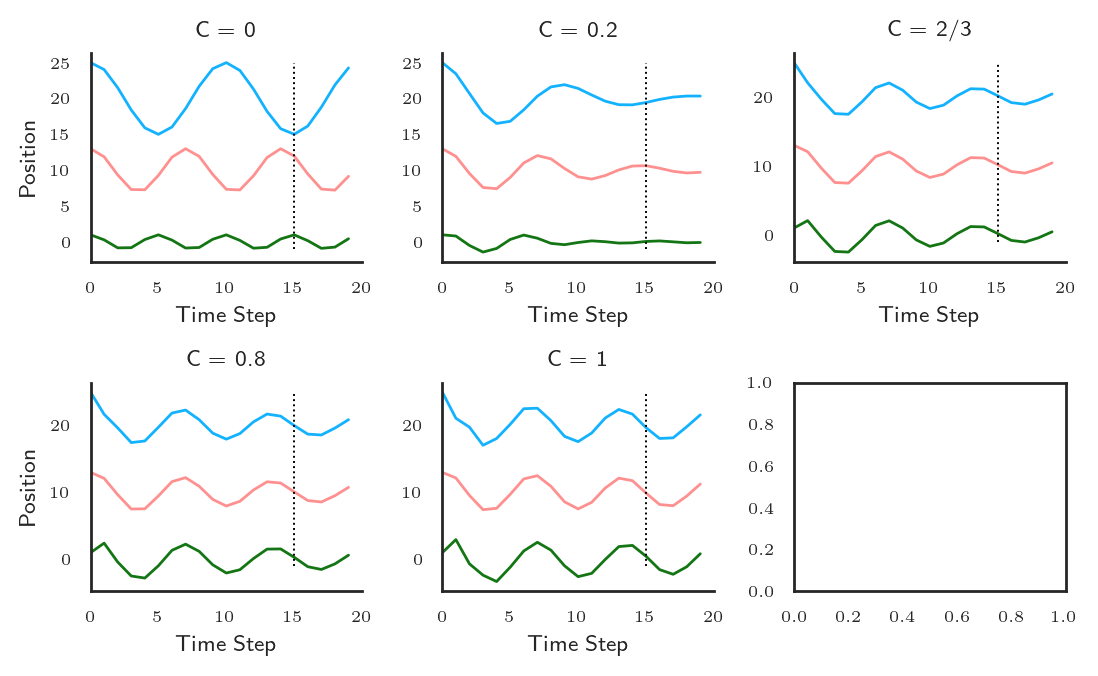

In [16]:
# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1, subplots=(2,3))  
fig, axs = plt.subplots(2, 3, figsize=(w,h*1.5))
axs[0,1].sharey(axs[0,0])
axs[1,1].sharey(axs[1,0])

v_pos = 15
x_slice = [0, T_Plot]

plot_spring_data(axs[0,0], spring_uncoordinated_data, title=f"C = 0", y_shift_fn=lambda x, s: x + s*10)
axs[0,0].plot([v_pos, v_pos], [-1, 25], linestyle="dotted", linewidth=0.7, color="black")
axs[0,0].set_xlim(x_slice)
plot_spring_data(axs[0,1], spring_0_2_data, title=f"C = 0.2", line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[0,1].plot([v_pos, v_pos], [-1, 25], linestyle="dotted", linewidth=0.7, color="black")
axs[0,1].set_xlim(x_slice)
plot_spring_data(axs[0,2], spring_coordinated_data, title=f"C = 2/3", line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[0,2].plot([v_pos, v_pos], [-1, 25], linestyle="dotted", linewidth=0.7, color="black")
axs[0,2].set_xlim(x_slice)
plot_spring_data(axs[1,0], spring_0_8_data, title=f"C = 0.8", line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[1,0].plot([v_pos, v_pos], [-1, 25], linestyle="dotted", linewidth=0.7, color="black")
axs[1,0].set_xlim(x_slice)
plot_spring_data(axs[1,1], spring_supercoordinated_data, title=f"C = 1", line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[1,1].plot([v_pos, v_pos], [-1, 25], linestyle="dotted", linewidth=0.7, color="black")
axs[1,1].set_xlim(x_slice)

axs[0,1].set_ylabel("")
axs[0,2].set_ylabel("")
axs[1,1].set_ylabel("")
plt.tight_layout()

## b) Conversation

In [56]:
# Set parameters for data generation

# Denoised version is only used for plots
T_Plot = 200
config_bundle = ConversationConfigBundle()
config_bundle.sd_a = 0.  # only for plots
config_bundle.sd_o = 0.
config_bundle.num_time_steps_in_coordination_scale = T_Plot

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.zeros((1, T_Plot)))
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
conversation_uncoordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)) * 2/3)
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
conversation_coordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)))
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
conversation_supercoordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)) * 0.2)
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
conversation_0_2_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)) * 0.8)
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
conversation_0_8_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

# Noisy version for inference
config_bundle = ConversationConfigBundle()
config_bundle.num_time_steps_in_coordination_scale = T

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.zeros((1, T)))
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
noisy_conversation_uncoordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T)) * 2/3)
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
noisy_conversation_coordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T)))
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
noisy_conversation_supercoordinated_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T)) * 0.2)
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
noisy_conversation_0_2_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T)) * 0.8)
model = ConversationModel(config_bundle)
model.prepare_for_sampling()
noisy_conversation_0_8_data = model.draw_samples(seed=SEED).component_group_samples["observation"]

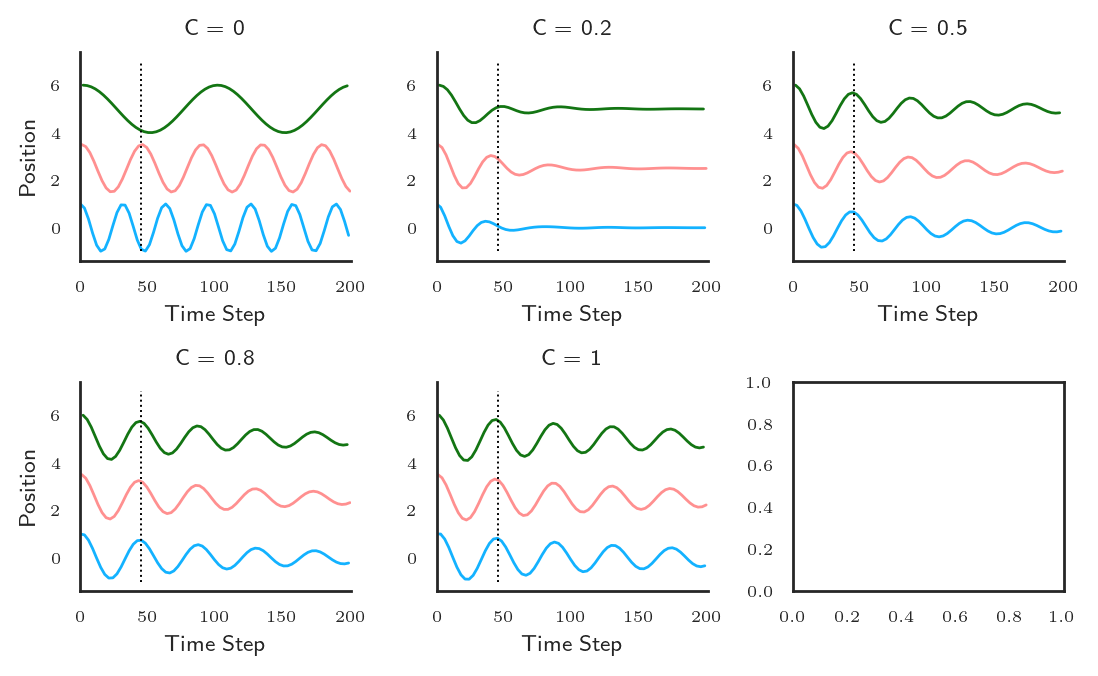

In [57]:
# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1, subplots=(2,3))  
fig, axs = plt.subplots(2, 3, figsize=(w,h*1.5))
axs[0,1].sharey(axs[0,0])
# axs[1,1].sharey(axs[1,0])

v_pos = 45
x_slice = [0, 200]

plot_conversation_data(axs[0,0], conversation_uncoordinated_data, title=f"C = 0", line_width=1, y_shift_fn=lambda x, s: x + s*2.5)
axs[0,0].set_xlim(x_slice)
axs[0,0].plot([v_pos, v_pos], [-1, 7], linestyle="dotted", linewidth=0.7, color="black")
plot_conversation_data(axs[0,1], conversation_0_2_data, title=f"C = 0.2", line_width=1, y_shift_fn=lambda x, s: x + s*2.5)
axs[0,1].set_xlim(x_slice)
axs[0,1].plot([v_pos, v_pos], [-1, 7], linestyle="dotted", linewidth=0.7, color="black")
plot_conversation_data(axs[0,2], conversation_coordinated_data, title=f"C = 0.5", line_width=1, y_shift_fn=lambda x, s: x + s*2.5)
axs[0,2].set_xlim(x_slice)
axs[0,2].plot([v_pos, v_pos], [-1, 7], linestyle="dotted", linewidth=0.7, color="black")
plot_conversation_data(axs[1,0], conversation_0_8_data, title=f"C = 0.8", line_width=1, y_shift_fn=lambda x, s: x + s*2.5)
axs[1,0].set_xlim(x_slice)
axs[1,0].plot([v_pos, v_pos], [-1, 7], linestyle="dotted", linewidth=0.7, color="black")
plot_conversation_data(axs[1,1], conversation_supercoordinated_data, title=f"C = 1", line_width=1, y_shift_fn=lambda x, s: x + s*2.5)
axs[1,1].set_xlim(x_slice)
axs[1,1].plot([v_pos, v_pos], [-1, 7], linestyle="dotted", linewidth=0.7, color="black")


axs[0,1].set_ylabel("")
axs[0,2].set_ylabel("")
axs[1,1].set_ylabel("")
plt.tight_layout()

# Experiments

## Helper Functions

In [30]:
def train(model: Any, 
          evidence: Any, 
          init_method: str = NUTS_INIT_METHOD,
          burn_in: int = BURN_IN, 
          num_samples: int = NUM_SAMPLES, 
          num_chains: int = NUM_CHAINS, 
          target_accept: float = TARGET_ACCEPT,
          seed : int = SEED):
    
    # Ignore PyMC warnings
    if not sys.warnoptions:
        import warnings
        warnings.simplefilter("ignore")
    
    # The environment variables below will make sure each chain does not take all the resources, slowing down inference.
    os.environ["MKL_NUM_THREADS"] = f"{num_chains}"
    os.environ["OMP_NUM_THREADS"] = f"{num_chains}"
    os.environ["OPENBLAS_NUM_THREADS"] = f"{num_chains}"
    
    model.clear_parameter_values()  # so we can infer them
    _, idata = model.fit(evidence=evidence, 
                         init_method=init_method,
                         burn_in=burn_in, 
                         num_samples=num_samples, 
                         num_chains=num_chains,
                         seed=seed, 
                         num_jobs=num_chains,
                         target_accept=target_accept)
    
    posterior_samples = CoordinationPosteriorSamples.from_inference_data(idata)
    
    # Plot parameter trace
    plot_parameter_trace(model, idata)

    # Plot coordination
    w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1)  
    fig = plt.figure(figsize=(w,h))
    
    posterior_samples.plot(fig.gca(), show_samples=False, line_width=1)
    plt.title("Coordination")
    
    return posterior_samples, idata

def plot_parameter_trace(model: Any, idata: Any):
    sampled_vars = set(idata.posterior.data_vars)
    var_names = sorted(list(set(model.parameter_names).intersection(sampled_vars)))    
    az.plot_trace(idata, var_names=var_names)
    plt.tight_layout()

def build_convergence_summary(idata: Any) -> pd.DataFrame:
    header = [
        "variable",
        "mean_rhat",
        "std_rhat"
    ]
    
    rhat = az.rhat(idata)
    data = []
    for var, values in rhat.data_vars.items():
        entry = [
            var,
            values.to_numpy().mean(),
            values.to_numpy().std()
        ]
        data.append(entry)

    return pd.DataFrame(data, columns=header)

def train_spring_model(evidence: ObservationSamples) -> InferenceData:
    bundle = SpringConfigBundle()
    model = SpringModel(bundle)
    bundle.observed_values = evidence.values[0]
    bundle.time_steps_in_coordination_scale = evidence.time_steps_in_coordination_scale[0]
    
    # Infer the parameters below as well
    bundle.sd_a = None
    bundle.sd_o = None
    bundle.mean_a0 = None
    bundle.mean_uc0 = None
    bundle.sd_uc = None
    
    model.clear_parameter_values()
    model.prepare_for_inference()
    model.create_random_variables()

    # Ignore PyMC warnings
    if not sys.warnoptions:
        import warnings
        warnings.simplefilter("ignore")
    
    # The environment variables below will make sure each chain does not take all the resources, 
    # slowing down inference.
    os.environ["MKL_NUM_THREADS"] = f"{NUM_CHAINS}"
    os.environ["OMP_NUM_THREADS"] = f"{NUM_CHAINS}"
    os.environ["OPENBLAS_NUM_THREADS"] = f"{NUM_CHAINS}"
    
    idata = model.fit(num_chains=NUM_CHAINS, burn_in=BURN_IN, num_samples=NUM_SAMPLES, target_accept=TARGET_ACCEPT)
    idata.plot_time_series_posterior("coordination", True, marker=None)
    idata.plot_parameter_posterior()
    print(idata.generate_convergence_summary())

    return idata    

## 1) No Coordination

### 1.1) Spring

In [ ]:
idata_spring_uncoordinated = train_spring_model(noisy_spring_uncoordinated_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coordination_mean_uc0, coordination_sd_uc, unbounded_coordination, state_space_mean_a0, state_space_sd_a, state_space, observation_sd_o]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 1.2) Conversation

In [ ]:
evidence = noisy_conversation_uncoordinated_data

c_posterior_conversation_uncoordinated, idata_conversation_uncoordinated = train(conversation_model, evidence)
build_convergence_summary(idata_conversation_uncoordinated)

## 2) Maximum Coordination

### 2.1) Spring

In [ ]:
idata_spring_coordinated = train_spring_model(noisy_spring_coordinated_data)

### 2.2) Conversation

In [ ]:
evidence = noisy_conversation_coordinated_data

c_posterior_conversation_coordinated, idata_conversation_coordinated = train(conversation_model, evidence)
build_convergence_summary(idata_conversation_coordinated)

## 3) Supercoordination

### 3.1) Spring

In [ ]:
idata_spring_supercoordinated = train_spring_model(noisy_spring_supercoordinated_data)

### 3.2) Conversation

In [ ]:
evidence = noisy_conversation_supercoordinated_data

c_posterior_conversation_supercoordinated, idata_conversation_supercoordinated = train(conversation_model, evidence)
build_convergence_summary(idata_conversation_supercoordinated)

## 4) Coordination = 0.2

### 4.1) Spring

In [ ]:
idata_spring_0_2 = train_spring_model(noisy_spring_0_2_data)

### 4.2) Conversation

In [ ]:
evidence = noisy_conversation_0_2_data

c_posterior_conversation_0_2, idata_conversation_0_2 = train(conversation_model, evidence)
build_convergence_summary(idata_conversation_0_2)

## 5) Coordination = 0.8

### 5.1) Spring

In [ ]:
idata_spring_0_8 = train_spring_model(noisy_spring_0_8_data)

### 5.2) Conversation

In [ ]:
evidence = noisy_conversation_0_8_data

c_posterior_conversation_0_8, idata_conversation_0_8 = train(conversation_model, evidence)
build_convergence_summary(idata_conversation_0_8)

# Final Plot

In [ ]:
def custom_formatter(x, pos):
    result = x
    if result == 0:
        return '0'
    # If not 0, format as multiples of 1000 (1K, 2K, 3K, etc.)
    return f'{result/1000:.1f}K'

def save_plot(image_name: str, fig: Any, format: str = "pdf"):
    fig.savefig(f"../assets/images/{image_name}.{format}", format=format, bbox_inches='tight', pad_inches=0)

## a) Spring

In [ ]:
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1, subplots=(2,3))  
fig, axs = plt.subplots(2, 3, figsize=(w, h*1.5))

v_pos = 15
x_slice = [0, 20]

axs[0,1].sharey(axs[0,0])
axs[1,1].sharey(axs[1,0])

# Data plots
plot_spring_data(axs[0,0], spring_uncoordinated_data, line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[0,0].set_ylabel("Spring Position")
axs[0,0].set_xlabel("Time Step")
axs[0,0].set_title("Data (c = 0)")
axs[0,0].set_xlim(x_slice)
axs[0,0].plot([v_pos, v_pos], [-2, 25], linestyle="dotted", linewidth=0.7, color="black")

plot_spring_data(axs[0,1], spring_0_2_data, line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[0,1].set_ylabel("")
axs[0,1].set_xlabel("Time Step")
axs[0,1].set_title("Data (c = 0.2)")
axs[0,1].set_xlim(x_slice)
axs[0,1].plot([v_pos, v_pos], [-2, 25], linestyle="dotted", linewidth=0.7, color="black")

plot_spring_data(axs[0,2], spring_coordinated_data, line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[0,2].set_ylabel("")
axs[0,2].set_xlabel("Time Step")
axs[0,2].set_title("Data (c = 2/3)")
axs[0,2].set_xlim(x_slice)
axs[0,2].plot([v_pos, v_pos], [-2, 25], linestyle="dotted", linewidth=0.7, color="black")

plot_spring_data(axs[1,0], spring_0_8_data, line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[1,0].set_ylabel("Spring Position")
axs[1,0].set_xlabel("Time Step")
axs[1,0].set_title("Data (c = 0.8)")
axs[1,0].set_xlim(x_slice)
axs[1,0].plot([v_pos, v_pos], [-2, 25], linestyle="dotted", linewidth=0.7, color="black")

plot_spring_data(axs[1,1], spring_supercoordinated_data, line_width=1, y_shift_fn=lambda x, s: x + s*10)
axs[1,1].set_ylabel("")
axs[1,1].set_xlabel("Time Step")
axs[1,1].set_title("Data (c = 1)")
axs[1,1].set_xlim(x_slice)
axs[1,1].plot([v_pos, v_pos], [-2, 25], linestyle="dotted", linewidth=0.7, color="black")

idata_spring_uncoordinated.plot_time_series_posterior("coordination", True, (0,1), axs[1,2], line_width=0.5, color="tab:red", label="c = 0")
idata_spring_0_2.plot_time_series_posterior("coordination", True, (0,1), axs[1,2], line_width=0.5, color="tab:red", label="c = 0.2")
idata_spring_coordinated.plot_time_series_posterior("coordination", True, (0,1), axs[1,2], line_width=0.5, color="tab:red", label="c = 2/3")
idata_spring_0_8.plot_time_series_posterior("coordination", True, (0,1), axs[1,2], line_width=0.5, color="tab:red", label="c = 0.8")
idata_spring_supercoordinated.plot_time_series_posterior("coordination", True, (0,1), axs[1,2], line_width=0.5, color="tab:red", label="c = 1")
axs[1,2].set_title("Inferred Coordination")
axs[1,2].set_xlabel("")
axs[1,2].set_ylabel("Coordination")
axs[1,2].set_xlabel("Time Step")
sns.despine(ax=axs[1,2])

handles, labels = axs[0,0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=[1.15, 0.9], frameon=True, markerscale=15, columnspacing=1.4, title="Spring")
for line in leg.get_lines():
    line.set_linewidth(1.5)

handles, labels = axs[1,2].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower right', ncol=1, bbox_to_anchor=[1.18, 0.13], frameon=True, markerscale=15, columnspacing=1.4, title="Coordination")
for line in leg.get_lines():
    line.set_linewidth(1.5)

plt.tight_layout()
# save_plot("results_spring_model", fig, "png")
# save_plot("results_spring_model", fig, "pdf")

## b) Conversation

In [ ]:
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1, subplots=(2,3))  
fig, axs = plt.subplots(2, 3, figsize=(w, h*1.5))

v_pos = 45
x_slice = [0, 200]

axs[0,1].sharey(axs[0,0])
axs[1,1].sharey(axs[1,0])

# Data plots
plot_conversation_data(axs[0,0], conversation_uncoordinated_data, y_shift_fn=lambda x, s: x + s*2.5)
axs[0,0].set_ylabel("Voice Intensity")
axs[0,0].set_xlabel("Time Step")
axs[0,0].set_title("Data (c = 0)")
axs[0,0].plot([v_pos, v_pos], [-2, 6], linestyle="dotted", linewidth=0.7, color="black")
axs[0,0].set_xlim(x_slice)

plot_conversation_data(axs[0,1], conversation_0_2_data, y_shift_fn=lambda x, s: x + s*2.5)
axs[0,1].set_ylabel("")
axs[0,1].set_xlabel("Time Step")
axs[0,1].set_title("Data (c = 0.2)")
axs[0,1].plot([v_pos, v_pos], [-2, 6], linestyle="dotted", linewidth=0.7, color="black")
axs[0,1].set_xlim(x_slice)

plot_conversation_data(axs[0,2], conversation_coordinated_data, y_shift_fn=lambda x, s: x + s*2.5)
axs[0,2].set_ylabel("")
axs[0,2].set_xlabel("Time Step")
axs[0,2].set_title("Data (c = 0.5)")
axs[0,2].plot([v_pos, v_pos], [-2, 6], linestyle="dotted", linewidth=0.7, color="black")
axs[0,2].set_xlim(x_slice)

plot_conversation_data(axs[1,0], conversation_0_8_data, y_shift_fn=lambda x, s: x + s*2.5)
axs[1,0].set_ylabel("Voice Intensity")
axs[1,0].set_xlabel("Time Step")
axs[1,0].set_title("Data (c = 0.8)")
axs[1,0].plot([v_pos, v_pos], [-2, 6], linestyle="dotted", linewidth=0.7, color="black")
axs[1,0].set_xlim(x_slice)

plot_conversation_data(axs[1,1], conversation_supercoordinated_data, y_shift_fn=lambda x, s: x + s*2.5)
axs[1,1].set_ylabel("")
axs[1,1].set_xlabel("Time Step")
axs[1,1].set_title("Data (c = 1)")
axs[1,1].plot([v_pos, v_pos], [-2, 6], linestyle="dotted", linewidth=0.7, color="black")
axs[1,1].set_xlim(x_slice)

c_posterior_conversation_uncoordinated.plot(axs[1,2], show_samples=False, line_width=0.5, color="tab:red", label="c = 0")
c_posterior_conversation_0_2.plot(axs[1,2], show_samples=False, line_width=0.5, color="tab:purple", label="c = 0.2")
c_posterior_conversation_coordinated.plot(axs[1,2], show_samples=False, line_width=0.5, color=MUSTARD, label="c = 0.5")
c_posterior_conversation_0_8.plot(axs[1,2], show_samples=False, line_width=0.5, color="tab:green", label="c = 0.8")
c_posterior_conversation_supercoordinated.plot(axs[1,2], show_samples=False, line_width=0.5, color="tab:blue", label="c = 1")
axs[1,2].set_title("Inferred Coordination")
axs[1,2].set_xlabel("")
axs[1,2].set_ylabel("Coordination")
axs[1,2].set_xlabel("Time Step")
sns.despine(ax=axs[1,2])

handles, labels = axs[0,0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=[1.15, 0.9], frameon=True, markerscale=15, columnspacing=1.4, title="Speaker")
for line in leg.get_lines():
    line.set_linewidth(1.5)

handles, labels = axs[1,2].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower right', ncol=1, bbox_to_anchor=[1.18, 0.13], frameon=True, markerscale=15, columnspacing=1.4, title="Coordination")
for line in leg.get_lines():
    line.set_linewidth(1.5)

plt.tight_layout()
plt.tight_layout()
save_plot("results_conversation_model", fig, "png")
save_plot("results_conversation_model", fig, "pdf")